# EDA and Modeling Notebook

This notebook is designed for AWS Amazon SageMaker Notebook instance type (ml.t2.xlarge).

## Import Necessary Modules

Depending on your environment you may need to install a few modules.

In [1]:
!pip install --upgrade pip

!pip install wordcloud

!pip install neattext

!pip install gensim

!pip install spacy

!pip install scikit-multilearn

!pip install imblearn

!pip install mglearn

In [2]:
import boto3
import re
import string
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().magic('matplotlib inline')

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, multilabel_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
# from imblearn.over_sampling import RandomOverSampler, SMOTE

import neattext as nt
import neattext.functions as nfx
import wordcloud
from wordcloud import WordCloud, STOPWORDS, tokenization

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer


pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", -1)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:42: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Read in Data

If your file is stored in an AWS s3 bucket, this is how you read in your data file. Please take a look at the link to find out more about uploading and retrieving data from an s3 bucket. 

https://docs.aws.amazon.com/AmazonS3/latest/userguide/UsingBucket.html

In [4]:
#Gather data from s3 bucket
bucketname = 'YOUR BUCKET NAME HERE'
filename = 'script_EDA_file.csv'

s3 = boto3.resource('s3')
s3.Bucket(bucketname).download_file(filename, '../../script_EDA_file.csv')

In [3]:
df = pd.read_csv("../../script_EDA_file.csv")

In [4]:
#Drop first column
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
#View data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1141 non-null   object
 1   text       1141 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [6]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Data Cleaning

For text data, data cleaning is a very important iterative step. I used regex along with other functions to remove unneccesary characters and digits from my text column.

In [7]:
#Function to clean 
def clean_text(text):
    #remove parenthesis and words within them
    text = re.sub("\(.*?\)", " ", text)
    # remove single letter characters
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    #remove punctuation marks
    text = re.sub("[%s]" % re.escape(string.punctuation), " ", text)
    #remove other unneccesary characters
    text = re.sub("[^\w\d' ]", " ", text)
    #remove digits
    text = re.sub('\w*\d\w*', " ", text)
    #remove capital words
    text = re.sub(r"(\b[A-Z]+\b)", " ", text)
    return text


df['text'] = df['text'].apply(clean_text)

In [9]:
#Split script column by words (tokenize)
df['text'] = df['text'].str.split()

In [12]:
#Create Movie title column using the text file names
df["movie_title"] = df["file_name"].apply(lambda x: x.split(".")[0].replace("_", " "))

In order to create my target columns (movie genres), I had to extract it from the bottom of each script. The following three cells is my process of pulling the text that contained the genre, putting it into a new column, and then separating them into list format (they were not previously separated). Depending on the format of your text file, you may not have to do these steps.

In [14]:
#Pull last couple of words from script to extract genre
df['Genres'] = df['text'].apply(lambda x: x[-40:])

In [16]:
# Separate Genre into a separate column

def pull_genre(column):
    newlst = []
    [newlst.append(column[i + 1]) for i, word in enumerate(column) if word == "Genres"]
    return newlst

df['genre'] = df['Genres'].apply(lambda x: pull_genre(x))
# df['Genres'].apply(lambda x: pull_genre(x))

df.drop(columns = ['Genres'], axis = 1, inplace = True)

df['genre'] = df['genre'].apply(lambda x: x[0])


In [17]:
#Split Genre into Lists
def split_genres(genres):
    return re.sub( r"([A-Z])", r" \1", genres).split()

df['genre'] = df['genre'].apply(lambda x: split_genres(str(x)))

In [18]:
def del_writers(text):
    for i, word in enumerate(text):
        if word == "Writers":
            del text[i:]
    return text
        
df['text'] = df['text'].apply(lambda x: del_writers(x))

### Removing Stop Words

In [20]:
#Utlizing stopwords from multiple libraries
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

gensim_stopwords = list(gensim.parsing.preprocessing.STOPWORDS)

wordcloud_stopwords = list(wordcloud.STOPWORDS)

neattext_stopwords = list(nt.STOPWORDS_en)

In [21]:
# setting stopwords and punctuations
import string, re

stop_words_list = stopwords.words('english')
stop_words_list += gensim_stopwords
stop_words_list += spacy_stopwords
stop_words_list += wordcloud_stopwords
stop_words_list += neattext_stopwords
stop_words_list += list(string.punctuation)
stop_words_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
                    'hand', 'written', 'com', '-', '–', '—', 'come', 'take', 'got']
stop_words_list += ["b", "look", "s", "nt", "like", "re", "door", "know", "away", "back", 'looks', 
                    "n't", 'takes', 'right', 'head', 'hand', 'theres', 'sees', 'let', 'lets']
stop_words_list += ['turns', 'want', 'going', 'looking', 'takes', 'face', 'hands', 'll']
stop_words_list += ['hes', 'thats', 'man', 'time', 'think', 'way', 'cant', 'oh', 'little', 'walks', 
                    'open', 'yeah', 'pulls' ,'tell','sits' ,'starts' ,'comes' ,'na', 'eyes', 'something',
                    'goes', 'beat', 'people', 'long', 'stands', 'theres' 'sees', 'gets', 'phone', 'okay', 'mr', 
                    'window', 'moment', 'table', 'whats', 'suddenly' ,'gon','need', 'moves', 'opens', 'floor', 
                    'house' ,'hear', 'smiles', 'thing', 'stops', 'sure', 'inside', 'theyre', 'said', 'de', 
                    'la', 'le', 'watch', 'imsdb', 'user', 'comment', 'offscreen', 'www', 'fi']
stop_words_set = set(stop_words_list)

In [22]:
# Turn text column into strings for preprocessing purposes
df['text'] = df['text'].apply(lambda x: " ".join(x))

In [24]:
# Define function that removes stopwords and tokenizes text column
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words_set]
    return stopwords_removed 

# applying the above function to our text column
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
# df['text'].apply(lambda x: remove_stopwords(x))

In [25]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0  [cary, joji, fukunaga, based, novel, uzodinma, iweala, dialogue, screenplay, faithful, form, novel, originally, lighter, form, nigerian, pidgin, english, known, krio, krio, lingua, franca, west, africa, gambia, cameroon, spoken, millions, accented, starting, angle, plastic, exterior, screen, television, children, running, circles, football, pitch, angle, boy, balancing, warm, smile, clever, littler, best, friend, ones, talent, agu, passes, line, lying, wheel, barrows, carrying, dike, kids, scouting, football, pitch, follow, suit, agu, dike, drop, stool, charming, agu, supposed, watching, massah, screen, imagination, agu, perform, framed, space, demolished, television, constable, unimpressed, garbage, agu, disappointed, discouraged, optimism, agu, white, helmeted, troops, humors, channels, agu, knob, swiftly, imagination, ...]                                                             
1  [stephen, chbosky, evan, spiliotopoulos, based, animated, film, beauty, beast, screenplay, linda, woolverton, august, resplendent, bespeaking, great, wealth, power, grounds, stonework, immaculate, hidden, heart, france, handsome, young, prince, lived, beautiful, castle, single, clinging, rose, bush, stormy, spring, night, plucks, rose, heart, desired, prince, selfish, unkind, groomed, servants, faces, paints, exotic, animal, mask, prince, feather, brush, drapes, prince, elaborately, bejeweled, coat, taxed, village, castle, beautiful, objects, dusts, wig, powder, poof, poof, holds, indicating, running, late, master, haughty, wave, prince, instructs, bring, light, oui, matre, lifted, preening, prince, ornate, parties, beautiful, ornate, room, filled, corners, world, display, prince, pleasure, circle, eligible, maidens, bow, ...]                                                            
2  [beavis, butt, america, mike, judge, joe, stillman, location, href, location, href, mike, judge, joe, stillman, movie, begins, scenes, screaming, horror, running, streets, big, city, ground, shakes, giant, footsteps, pieces, building, debris, falling, getting, crushed, power, lines, coming, complete, pandemonium, japanese, animated, king, kong, godzilla, movie, footsteps, getting, closer, ground, shaking, intense, debris, falling, frame, smash, national, guard, truck, pan, white, socks, red, shorts, shirt, familiar, huh, huh, huh, huge, sound, butt, kong, continues, path, destruction, stomping, cars, buildings, saying, cool, huh, huh, huh, airplanes, tanks, start, firing, butt, irritated, says, cut, butt, munch, butt, swats, planes, sending, crashing, ground, stomps, ...]                                                                                                                    
3  [mike, mills, single, daisy, vase, kitchen, clicks, light, closet, rack, parents, clothes, begins, box, marked, home, box, marked, thrift, oliver, enters, bathroom, 

Due to the format of my raw data, I knew that all the words that were in all capital letters were either stage directions, character names, or location names. I removed capitalized words in order to clean the data, and get the text down to just the dialogue between characters in each script.

In [14]:
# Turn text column into strings for preprocessing purposes
# df['text'] = df['text'].apply(lambda x: " ".join(x))

In [26]:
#Save data to csv along the way
# df.to_csv("../../justincase_nocaps.csv", index = False)

### Multi-Label Binarizer

My target data involves several labels, so I implemented the multi-label binarizer from sklearn's preprocessing library to convert my genre column into columns and assign a "1" for movies with that particular genre and a "0" for all other movies.

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarise labels
mlb = MultiLabelBinarizer()
expandedGenreData = mlb.fit_transform(df['genre'])
labelClasses = mlb.classes_


# Create a pandas.DataFrame from our output
expandedGenres = pd.DataFrame(expandedGenreData, columns=labelClasses)

In [28]:
#concat dataframes back together
df_concat = pd.concat([df, expandedGenres], axis=1)

In [29]:
df_concat

file_name  \
0     Beasts_of_No_Nation.txt               
1     Beauty_and_the_Beast.txt              
2     Beavis_and_Butt-head_Do_America.txt   
3     Beginners.txt                         
4     Being_Human.txt                       
...               ...                       
1136  Battle_of_Shaker_Heights.txt          
1137  Battle:_Los_Angeles.txt               
1138  Bean.txt                              
1139  Beach.txt                             
1140  Beasts_of_the_Southern_Wild.txt       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 text  \
0     [cary, joji, fukunaga, based, novel, uzodinma, iweala, dialogue, screenplay, faithful, form, novel, originally, lighter, form, nigerian, pidgin, english, known, krio, krio, lingua, franca, west, africa, gambia, cameroon, spoken, millions, accented, starting, angle, plastic, exterior, screen, television, children, running, circles, football, pitch, angle, boy, balancing, warm, smile, clever, littler, best, friend, ones, talent, agu, passes, line, lying, wheel, barrows, carrying, dike, kids, scouting, football, pitch, follow, suit, agu, dike, drop, stool, charming, agu, supposed, watching, massah, screen, imagination, agu, perform, framed, space, demolished, television, constable, unimpressed, garbage, agu, disappointed, discouraged, optimism, agu, white, helmeted, troops, humors, channels, agu, knob, swiftly, imagination, ...]                                                             
1     [stephen, chbosky, evan, spiliotopoulos, based, animated, film, beauty, beast, screenplay, linda, woolverton, august, resplendent, bespeaking, great, wealth, power, grounds, stonework, immaculate, hidden, heart, france, handsome, young, prince, lived, beautiful, castle, single, clinging, rose, bush, stormy, spring, night, plucks, rose, heart, desired, prince, selfish, unkind, groomed, servants, faces, paints, exotic, animal, mask, prince, feather, brush, drapes, prince, elaborately, bejeweled, coat, taxed, village, castle, beautiful, objects, dusts, wig, powder, poof, poof, holds, indicating, running, late, master, haughty, wave, prince, instructs, bring, light, oui, matre, lifted, preening, prince, ornate, parties, beautiful, ornate, room, filled, corners, world, display, prince, pleasure, circle, eligible, maidens, bow, ...]                                                            
2     [beavis, butt, america, mike, judge, joe, stillman, location, href, location, href, mike, judge, joe, stillman, movie, begins, scenes, screaming, horror, running, streets, big, city, ground, shakes, giant, footsteps, pieces, building, debris, falling, getting, crushed, power, lines, coming, complete, pandemonium, japanese, animated, king, kong, godzilla, movie, footsteps, getting, closer, ground, shaking, intense, debris, falling, frame, smash, national, guard, truck, pan, white, socks, red, shorts, shirt, familiar, huh, huh, huh, huge, sound, butt, kong, continues, path, destruction, stomping, cars, buildings, saying, cool, huh, huh, huh, airplanes, tanks, start, firing, butt, irritated, says, cut, butt, munch, butt, swats, planes, sending, crashing, ground, 

During preprocessing the genre names with "-" were cut and so I am returning the column names back to their original form.

In [30]:
#Rename some columns
df_concat.rename(columns={'Film': 'Film-Noir', 'Sci': 'Sci-Fi'}, inplace=True)

In [69]:
# Turn text column into strings for preprocessing purposes
# df_concat['text'] = df_concat['text'].apply(lambda x: " ".join(x))

In [71]:
#Save data to csv along the way
# df_concat.to_csv("../../justincase.csv", index = False)

In [31]:
#Save data to csv along the way
# df_concat.to_csv("../../no_caps_script.csv", index = False)

### Frequency Distribution

In [3]:
df = pd.read_csv("../../no_caps_script.csv")

In [4]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [111]:
# type(df.text)

pandas.core.series.Series

In [34]:
# df['text'].apply(lambda x: pd.Series.to_string(x))

In [8]:
# def remove_stopwords(text):
#     tokens = nltk.word_tokenize(text)
#     stopwords_removed = [token for token in tokens]
#     return stopwords_removed 

In [35]:
# df['text'].apply(lambda x: remove_stopwords(x))

In [99]:
#Split script column by words (tokenize)
# df['text'] = df['text'].str.split(" ")

In [36]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [37]:
# Turn text column into strings for preprocessing purposes
# df['text'].apply(lambda x: " ".join(str(x)))

In [88]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0  [cary, joji, fukunaga, based, novel, uzodinma, iweala, dialogue, screenplay, faithful, form, novel, originally, lighter, form, nigerian, pidgin, english, known, krio, krio, lingua, franca, west, africa, gambia, cameroon, spoken, millions, accented, starting, angle, plastic, exterior, screen, television, children, running, circles, football, pitch, angle, boy, balancing, warm, smile, clever, littler, best, friend, ones, talent, agu, passes, line, lying, wheel, barrows, carrying, dike, kids, scouting, football, pitch, follow, suit, agu, dike, drop, stool, charming, agu, supposed, watching, massah, screen, imagination, agu, perform, framed, space, demolished, television, constable, unimpressed, garbage, agu, disappointed, discouraged, optimism, agu, white, helmeted, troops, humors, channels, agu, knob, swiftly, imagination, ...]                                                             
1  [stephen, chbosky, evan, spiliotopoulos, based, animated, film, beauty, beast, screenplay, linda, woolverton, august, resplendent, bespeaking, great, wealth, power, grounds, stonework, immaculate, hidden, heart, france, handsome, young, prince, lived, beautiful, castle, single, clinging, rose, bush, stormy, spring, night, plucks, rose, heart, desired, prince, selfish, unkind, groomed, servants, faces, paints, exotic, animal, mask, prince, feather, brush, drapes, prince, elaborately, bejeweled, coat, taxed, village, castle, beautiful, objects, dusts, wig, powder, poof, poof, holds, indicating, running, late, master, haughty, wave, prince, instructs, bring, light, oui, matre, lifted, preening, prince, ornate, parties, beautiful, ornate, room, filled, corners, world, display, prince, pleasure, circle, eligible, maidens, bow, ...]                                                            
2  [beavis, butt, america, mike, judge, joe, stillman, location, href, location, href, mike, judge, joe, stillman, movie, begins, scenes, screaming, horror, running, streets, big, city, ground, shakes, giant, footsteps, pieces, building, debris, falling, getting, crushed, power, lines, coming, complete, pandemonium, japanese, animated, king, kong, godzilla, movie, footsteps, getting, closer, ground, shaking, intense, debris, falling, frame, smash, national, guard, truck, pan, white, socks, red, shorts, shirt, familiar, huh, huh, huh, huge, sound, butt, kong, continues, path, destruction, stomping, cars, buildings, saying, cool, huh, huh, huh, airplanes, tanks, start, firing, butt, irritated, says, cut, butt, munch, butt, swats, planes, sending, crashing, ground, stomps, ...]                                                                                                                    
3  [mike, mills, single, daisy, vase, kitchen, clicks, light, closet, rack, parents, clothes, begins, box, marked, home, box, marked, thrift, oliver, enters, bathroom, 

In [45]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms)
#     print(d['word'].values)
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word", palette=("winter_r"))
    ax.set(ylabel = 'Word') 
    plt.show()

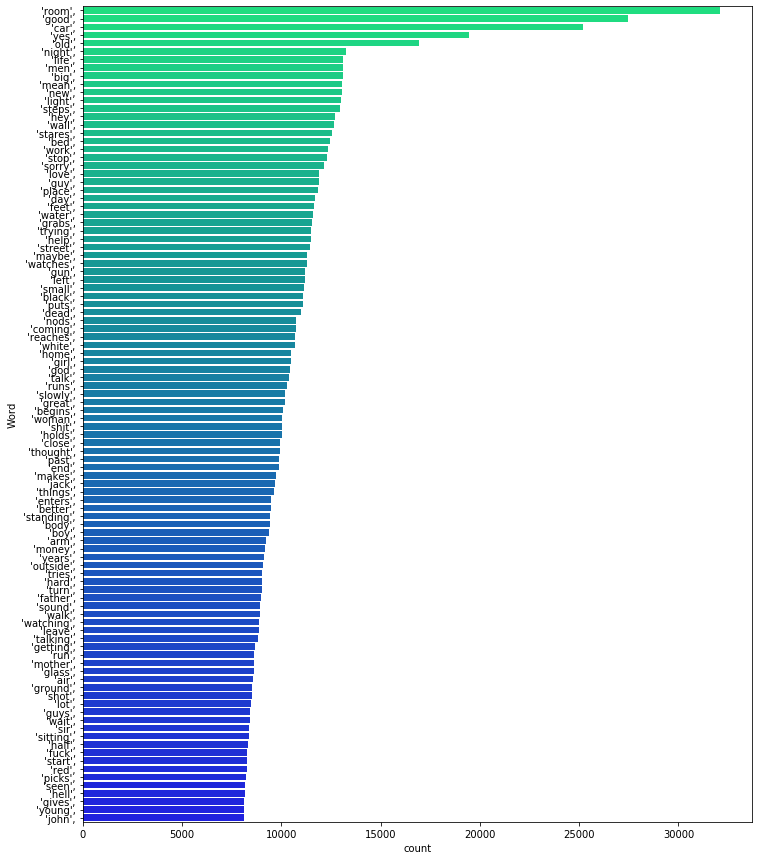

In [46]:
# print 100 most frequent words 
freq_words(df['text'], 100)

In [47]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [41]:
# Turn text column into strings for preprocessing purposes
# df['text'] = df['text'].apply(lambda x: " ".join(x))

In [49]:
df.head()

file_name  \
0  Beasts_of_No_Nation.txt               
1  Beauty_and_the_Beast.txt              
2  Beavis_and_Butt-head_Do_America.txt   
3  Beginners.txt                         
4  Being_Human.txt                       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [48]:
df.to_csv("../../no_stop_words.csv", index = False)

### Lemmitization

In [5]:
df2 = pd.read_csv("../../no_stop_words.csv")

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [6]:
df2.head()

file_name  \
0              Beasts_of_No_Nation.txt   
1             Beauty_and_the_Beast.txt   
2  Beavis_and_Butt-head_Do_America.txt   
3                        Beginners.txt   
4                      Being_Human.txt   

                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0  ['cary', 'joji', 'fukunaga', 'based', 'novel', 'uzodinma', 'iweala', 'dialogue', 'screenplay', 'faithful', 'form', 'novel', 'originally', 'lighter', 'form', 'nigerian', 'pidgin', 'english', 'known', 'krio', 'krio', 'lingua', 'franca', 'west', 'africa', 'gambia', 'cameroon', 'spoken', 'millions', 'accented', 'starting', 'angle', 'plastic', 'exterior', 'screen', 'television', 'children', 'runnin...   
1  ['stephen', 'chbosky', 'evan', 'spiliotopoulos', 'based', 'animated', 'film', 'beauty', 'beast', 'screenplay', 'linda', 'woolverton', 'august', 'resplendent', 'bespeaking', 'great', 'wealth', 'power', 'grounds', 'stonework', 'immaculate', 'hidden', 'heart', 'france', 'handsome', 'young', 'prince', 'lived', 'beautiful', 'castle', 'single', 'clinging', 'rose', 'bush', 'stormy', 'spring', 'night'...   
2  ['beavis', 'butt', 'america', 'mike', 'judge', 'joe', 'stillman', 'location', 'href', 'location', 'href', 'mike', 'judge', 'joe', 'stillman', 'movie', 'begins', 'scenes', 'screaming', 'horror', 'running', 'streets', 'big', 'city', 'ground', 'shakes', 'giant', 'footsteps', 'pieces', 'building', 'debris', 'falling', 'getting', 'crushed', 'power', 'lines', 'coming', 'complete', 'pandemonium', 'ja...   
3  ['mike', 'mills', 'single', 'daisy', 'vase', 'kitchen', 'clicks', 'light', 'closet', 'rack', 'parents', 'clothes', 'begins', 'box', 'marked', 'home', 'box', 'marked', 'thrift', 'oliver', 'enters', 'bathroom', 'flushes', 'bottle', 'bottle', 'pills', 'liquids', 'toilet', 'struggles', 'old', 'toothbrush', 'hairbrush', 'bottles', 'tubes', 'sink', 'stares', 'throws', 'oliver', 'hauls', 'trash', 'ou...   
4  ['forsyth', 'january', 'warner', 'boulevard', 'burbank', 'california', 'rights', 'reserved', 'stared', 'sky', 'listened', 'cow', 'mooing', 'dreamily', 'distant', 'village', 'tried', 'understand', 'meant', 'sky', 'fields', 'humming', 'telegraph', 'pole', 'felt', 'point', 'understanding', 'started', 'spin', 'lucid', 'languor', 'intolerable', 'vladimir', 'nabokov', 'script', 'main', 'characters',...   

                       movie_title                             genre  Action  \
0              Beasts of No Nation                  ['Drama', 'War']       0   
1             Beauty and the Beast  ['Family', 'Fantasy', 'Musical']       0   
2  Beavis and Butt-head Do America           ['Animation', 'Comedy']       0   
3                        Beginners    ['Comedy', 'Drama', 'Romance']       0   
4                      Being Human    ['Comedy', 'Drama', 'Fantasy']       0   

   Adventure  Animation  Biography  Comedy  Crime  Drama  Family  Fantasy  \
0          0          0          0       0      0      1       0        0   
1          0          0          0       0      0      0       1        1   
2          0          1          0       1      0      0       0        0   
3          0          0          0       1      0      1       0        0   
4          0          0          0       1      0      1       0        1   

   Film-Noir  History  Horror  Music  Musical  Mystery  Romance  Sci-Fi  \
0          0        0       0      0        0        0        0       0   
1          0        0       0      0        1        0        0       0   
2          0        0       0      0        0        0        0       0   
3          0        0       0      0        0        0        1       0   
4          0        

In [7]:
#Delist text column for preprocessing purposes
# df2['text'] = df2['text'].apply(eval).apply(' '.join)
df2['text'] = df2['text'].apply(eval).apply(' '.join)

In [8]:
df2.head()

file_name  \
0              Beasts_of_No_Nation.txt   
1             Beauty_and_the_Beast.txt   
2  Beavis_and_Butt-head_Do_America.txt   
3                        Beginners.txt   
4                      Being_Human.txt   

                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0  cary joji fukunaga based novel uzodinma iweala dialogue screenplay faithful form novel originally lighter form nigerian pidgin english known krio krio lingua franca west africa gambia cameroon spoken millions accented starting angle plastic exterior screen television children running circles football pitch angle boy balancing warm smile clever littler best friend ones talent agu passes line ly...   
1  stephen chbosky evan spiliotopoulos based animated film beauty beast screenplay linda woolverton august resplendent bespeaking great wealth power grounds stonework immaculate hidden heart france handsome young prince lived beautiful castle single clinging rose bush stormy spring night plucks rose heart desired prince selfish unkind groomed servants faces paints exotic animal mask prince feathe...   
2  beavis butt america mike judge joe stillman location href location href mike judge joe stillman movie begins scenes screaming horror running streets big city ground shakes giant footsteps pieces building debris falling getting crushed power lines coming complete pandemonium japanese animated king kong godzilla movie footsteps getting closer ground shaking intense debris falling frame smash nat...   
3  mike mills single daisy vase kitchen clicks light closet rack parents clothes begins box marked home box marked thrift oliver enters bathroom flushes bottle bottle pills liquids toilet struggles old toothbrush hairbrush bottles tubes sink stares throws oliver hauls trash outside adding large pile bags older jack russell terrier follows oliver arthur sit office surrounded papers boxes books tra...   
4  forsyth january warner boulevard burbank california rights reserved stared sky listened cow mooing dreamily distant village tried understand meant sky fields humming telegraph pole felt point understanding started spin lucid languor intolerable vladimir nabokov script main characters inhabit different periods pre history present day story blend developing narrative lives suggestion travel inca...   

                       movie_title                             genre  Action  \
0              Beasts of No Nation                  ['Drama', 'War']       0   
1             Beauty and the Beast  ['Family', 'Fantasy', 'Musical']       0   
2  Beavis and Butt-head Do America           ['Animation', 'Comedy']       0   
3                        Beginners    ['Comedy', 'Drama', 'Romance']       0   
4                      Being Human    ['Comedy', 'Drama', 'Fantasy']       0   

   Adventure  Animation  Biography  Comedy  Crime  Drama  Family  Fantasy  \
0          0          0          0       0      0      1       0        0   
1          0          0          0       0      0      0       1        1   
2          0          1          0       1      0      0       0        0   
3          0          0          0       1      0      1       0        0   
4          0          0          0       1      0      1       0        1   

   Film-Noir  History  Horror  Music  Musical  Mystery  Romance  Sci-Fi  \
0          0        0       0      0        0        0        0       0   
1          0        0       0      0        1        0        0       0   
2          0        0       0      0        0        0        0       0   
3          0        0       0      0        0        0        1       0   
4          0        

In [55]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
lst = ['novel', 'originally', 'lighter', 'form', 'nigerian', 'pidgin', 'english', 'known', 'krio', 'krio', 'lingua', 'franca', 'west', 'africa', 'gambia', 'cameroon', 'spoken', 'millions', 'accented', 'starting', 'angle', 'plastic', 'exterior', 'screen', 'television'] 

In [10]:
nltk.pos_tag(lst)[0][1]

'RB'

In [11]:
for x in lst:
    print(x)

novel
originally
lighter
form
nigerian
pidgin
english
known
krio
krio
lingua
franca
west
africa
gambia
cameroon
spoken
millions
accented
starting
angle
plastic
exterior
screen
television


In [59]:
from nltk.corpus import wordnet

In [12]:
get_wordnet_pos(word)

NameError: name 'get_wordnet_pos' is not defined

In [18]:
sentence1 = ["The", "striped", "bats", "are", "hanging", "on", "their", "feet", "for", "best"]

In [13]:
df2.text[0]

'cary joji fukunaga based novel uzodinma iweala dialogue screenplay faithful form novel originally lighter form nigerian pidgin english known krio krio lingua franca west africa gambia cameroon spoken millions accented starting angle plastic exterior screen television children running circles football pitch angle boy balancing warm smile clever littler best friend ones talent agu passes line lying wheel barrows carrying dike kids scouting football pitch follow suit agu dike drop stool charming agu supposed watching massah screen imagination agu perform framed space demolished television constable unimpressed garbage agu disappointed discouraged optimism agu white helmeted troops humors channels agu knob swiftly imagination channel addresses lieutenant amused treasure giving foods lieutenant motions carrier corporal agu reviews food lieutenant pack gum pocket sweeten deal agu snatches takings giving cash dike recruits agu home dike arguing playfully cheap puttering chinese motorcycle gi

In [14]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [20]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]

In [22]:
lemmatize_text(df2.text[0])

['cary',
 'joji',
 'fukunaga',
 'base',
 'novel',
 'uzodinma',
 'iweala',
 'dialogue',
 'screenplay',
 'faithful',
 'form',
 'novel',
 'originally',
 'lighter',
 'form',
 'nigerian',
 'pidgin',
 'english',
 'know',
 'krio',
 'krio',
 'lingua',
 'franca',
 'west',
 'africa',
 'gambia',
 'cameroon',
 'spoken',
 'million',
 'accent',
 'start',
 'angle',
 'plastic',
 'exterior',
 'screen',
 'television',
 'child',
 'run',
 'circle',
 'football',
 'pitch',
 'angle',
 'boy',
 'balance',
 'warm',
 'smile',
 'clever',
 'littler',
 'best',
 'friend',
 'one',
 'talent',
 'agu',
 'pass',
 'line',
 'lie',
 'wheel',
 'barrow',
 'carry',
 'dike',
 'kid',
 'scout',
 'football',
 'pitch',
 'follow',
 'suit',
 'agu',
 'dike',
 'drop',
 'stool',
 'charm',
 'agu',
 'suppose',
 'watch',
 'massah',
 'screen',
 'imagination',
 'agu',
 'perform',
 'frame',
 'space',
 'demolish',
 'television',
 'constable',
 'unimpressed',
 'garbage',
 'agu',
 'disappointed',
 'discourage',
 'optimism',
 'agu',
 'white',
 'h

In [ ]:
df2['texts'] = df2['text'].apply(lambda x: lemmatize_text(x))

In [78]:
# word = 'feet'
# print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

foot


In [104]:
# def lemmatize_text(text):
#     tokens = nltk.word_tokenize(text)
#     lemmatizer = WordNetLemmatizer()
#     return [lemmatizer.lemmatize(w) for w in tokens]

# df2['text'].apply(lemmatize_text)

KeyboardInterrupt: 

In [82]:
# for x in lst:
#     print(lemmatizer.lemmatize(x, get_wordnet_pos(x)))

novel
originally
lighter
form
nigerian
pidgin
english
know
krio
krio
lingua
franca
west
africa
gambia
cameroon
spoken
million
accent
start
angle
plastic
exterior
screen
television


In [62]:
# get_wordnet_pos(lst)

In [ ]:
df2.head()

In [14]:
df2.to_csv('../../lemm_data.csv', index = False)

### Frequency Distribution

In [3]:
df_lemm = pd.read_csv('../../lemm_data.csv')

pd.set_option("display.max_rows", 50, "display.max_columns", 50, "display.max_colwidth", 400)

In [62]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=5, stop_words="english")
df_cv = cv.fit_transform(df_lemm.text)
df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_lemm.movie_title
df_dtm

aa  aaa  aaaa  aaaaa  aaaaaaaah  aaaaaaah  \
movie_title                                                                  
Beasts of No Nation               0    0     0      0          0         0   
Beauty and the Beast              0    0     0      0          0         0   
Beavis and Butt-head Do America   0    0     0      0          0         0   
Beginners                         0    0     0      0          0         0   
Being Human                       0    0     0      0          0         0   
...                              ..  ...   ...    ...        ...       ...   
Battle of Shaker Heights          0    0     0      0          0         0   
Battle: Los Angeles               0    0     0      0          0         0   
Bean                              0    0     0      0          0         0   
Beach                             0    0     0      0          0         0   
Beasts of the Southern Wild       0    0     0      0          0         0   

                                 aaaaah  aaaah  aaaahhh  aaaahhhh  aaagh  \
movie_title                                                                
Beasts of No Nation                   0      0        0         0      0   
Beauty and the Beast                  0      0        0         0      0   
Beavis and Butt-head Do America       0      1        0         0      0   
Beginners                             0      0        0         0      0   
Being Human                           0      0        0         0      0   
...                                 ...    ...      ...       ...    ...   
Battle of Shaker Heights              0      0        0         0      0   
Battle: Los Angeles                   0      0        0         0      0   
Bean                                  0      0        0         0      0   
Beach                                 0      0        0         0      0   
Beasts of the Southern Wild           0      0        0         0      0   

                                 aaah  aaahh  aaargh  aagh  aah  aahh  aahhh  \
movie_title                                                                    
Beasts of No Nation                 0      0       0     0    0     0      0   
Beauty and the Beast                0      0       0     0    0     0      0   
Beavis and Butt-head Do America     1      0       0     1    0     0      0   
Beginners                           0      0       0     0    0     0      0   
Being Human                         0      0       0     0    0     0      0   
...                               ...    ...     ...   ...  ...   ...    ...   
Battle of Shaker Heights            0      0       0     0    0     0      0   
Battle: Los Angeles                 0      0       0     0    0     0      0   
Bean                                0      0       0     0    0     0      0   
Beach                               0      0       0     0    0     0      0   
Beasts of the Southern Wild         0      0       0     0    0     0      0   

                                 aahs  aaron  ab  aback  abacus  abandon  \
movie_title                                                                
Beasts of No Nation                 0      0   0      0       0        0   
Beauty and the Beast                0      0   0      1       0        0   
Beavis and Butt-head Do America     0      0   0      0       0        0   
Beginners                           0      0   0      0       0        0   
Being Human                         0      0   0      0       0        0   
...                               ...    ...  ..    ...     ...      ...   
Battle of Shaker Heights            0      0   0      2       0        0   
Battle: Los Angeles                 0      0   0      1       0        0   
Bean                                0      0   0      1       0        0   
Beach                               0      0   0      0       0        0   
Beasts of the Southern Wild         0      0   0      0       0        1   


In [67]:
import pickle
# Let's pickle it for later use
df_dtm.to_pickle("../../dtm.pkl")


## Visualizing Data

Below is the display of the distribution of movie scripts for each genre. There are several genres with a small amount of scripts and so they will be left out of the modeling process.

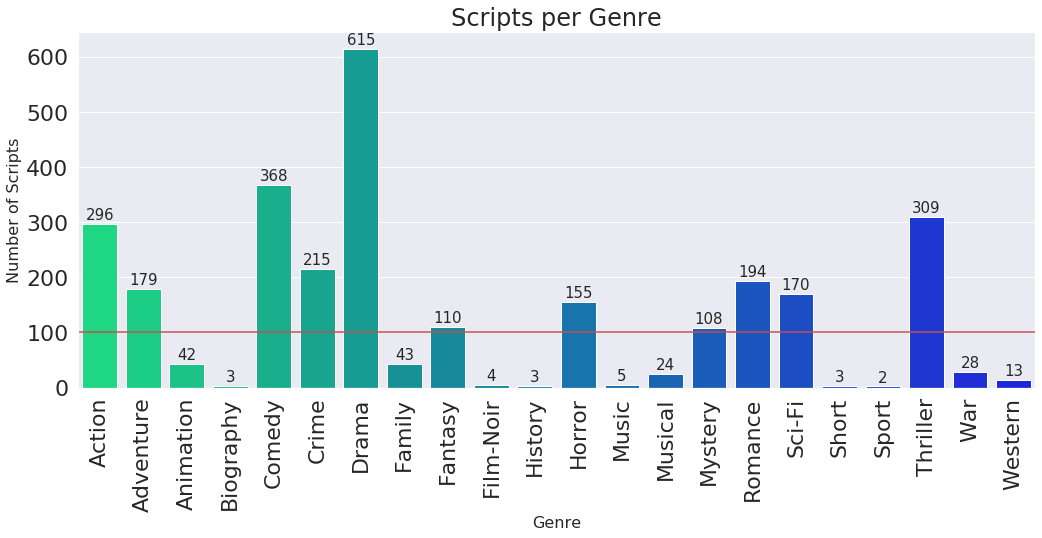

In [18]:
#Barplot for amount of scripts in each genre
categories = list(df_lemm.columns[4:].values)
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))
color = cm.winter_r(np.linspace(.4,.8, 30))

ax= sns.barplot(categories, df_lemm.iloc[:,4:].sum().values, palette=("winter_r"))


plt.axhline(100, color = 'r')
plt.title("Scripts per Genre", fontsize=24)
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Genre', fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='center')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size = 15,
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('../../scripts_per_genre.png')

plt.show()

Below is the display of the number of genres assigned to movies. There is one movie in my sample that has seven genres assigned to it. The majority of films in my sample have between one and four genres assigned to them.

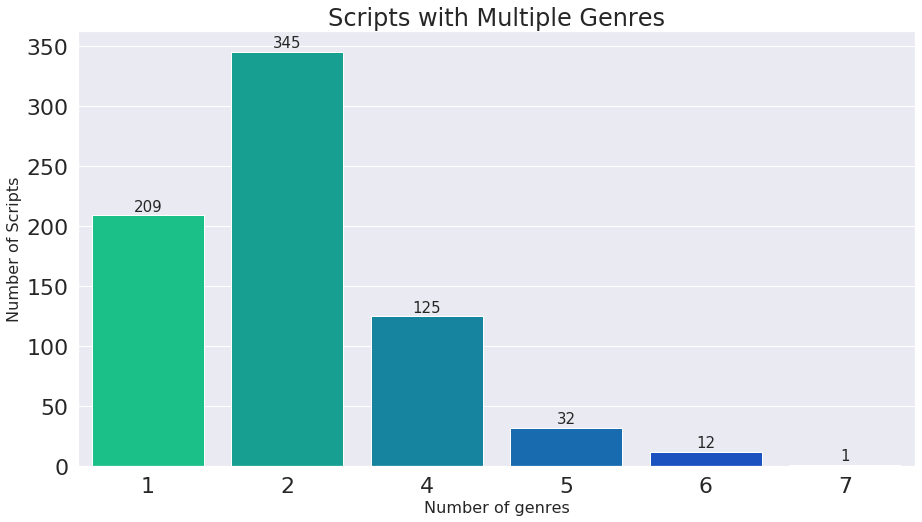

In [38]:
#Barplot for scripts that have multiple genres

rowSums = df_lemm.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2, style = 'darkgrid')
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, palette=("winter_r"))
# ax.grid(False)

plt.title("Scripts with Multiple Genres")
plt.ylabel('Number of Scripts', fontsize=16)
plt.xlabel('Number of genres', fontsize=16)

#adding the text labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                size = 15,
                xytext = (0, 9),
                textcoords = 'offset points')
    
plt.savefig('../../scripts_multiple_genre.png')

plt.show()

### Most Common Words Bar Graphs

Below is the process of creating frequency distribution for the words in the top four genres. Below is the display of which words appear the most in Drama, Comedy, Action, and Thriller movies.

In [20]:
#Setting separate dataframes for these genres
df_drama = df_lemm[df_lemm['Drama']==1]
df_comedy = df_lemm[df_lemm['Comedy']==1]
df_action = df_lemm[df_lemm['Action']==1]
df_thriller = df_lemm[df_lemm['Thriller']==1]

In [21]:
#Assigning variables to the text column for these genres
drama_text = df_drama['text']
comedy_text = df_comedy['text']
action_text = df_action['text']
thriller_text = df_thriller['text']

In [22]:
#Additional data cleaning
script_drama = list(map(new_clean, drama_text))
script_comedy = list(map(new_clean, comedy_text))
script_action = list(map(new_clean, action_text))
script_thriller = list(map(new_clean, thriller_text))

In [23]:

flat_drama = [sublist for sublist in script_drama]
flat_comedy = [sublist for sublist in script_comedy]
flat_action = [sublist for sublist in script_action]
flat_thriller = [sublist for sublist in script_thriller]

In [24]:
#tokenize text for each genre
drama_token = nltk.word_tokenize(str(flat_drama))
comedy_token = nltk.word_tokenize(str(flat_comedy))
action_token = nltk.word_tokenize(str(flat_action))
thriller_token = nltk.word_tokenize(str(flat_thriller))

In [25]:
#create frequency distribution for following genres
drama_freq = FreqDist(drama_token)
comedy_freq = FreqDist(comedy_token)
action_freq = FreqDist(action_token)
thriller_freq = FreqDist(thriller_token)

In [26]:
# Top 20 thriller words:
# thriller_freq.most_common(25)

In [27]:
# create counts of genre with values and words
drama_bar_counts = [x[1] for x in drama_freq.most_common(25)]
drama_bar_words = [x[0] for x in drama_freq.most_common(25)]

comedy_bar_counts = [x[1] for x in comedy_freq.most_common(25)]
comedy_bar_words = [x[0] for x in comedy_freq.most_common(25)]

action_bar_counts = [x[1] for x in action_freq.most_common(25)]
action_bar_words = [x[0] for x in action_freq.most_common(25)]

thriller_bar_counts = [x[1] for x in thriller_freq.most_common(25)]
thriller_bar_words = [x[0] for x in thriller_freq.most_common(25)]

In [28]:
# setting the color of our bar graphs
color = cm.winter_r(np.linspace(.4,.8, 30))

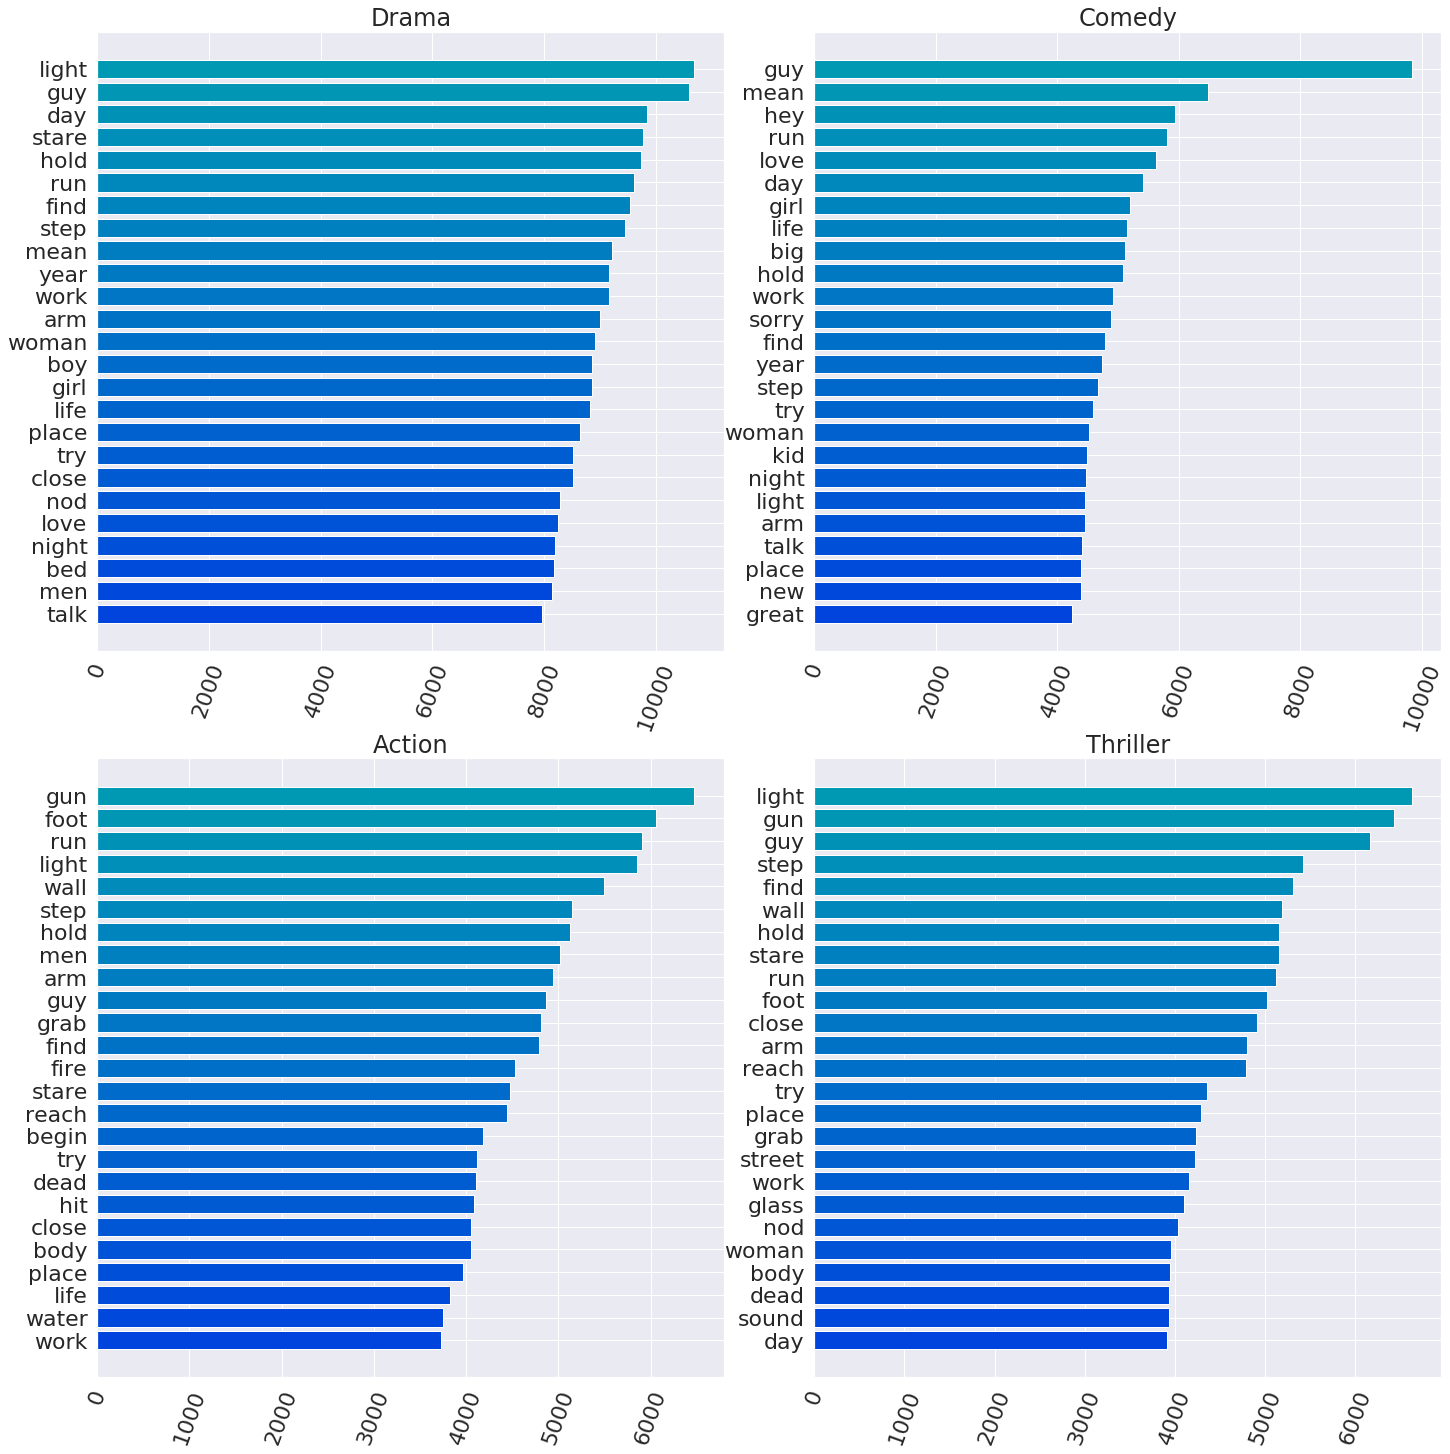

In [29]:
#Plot each graph on a different axis
new_figure = plt.figure(figsize=(20,20))

ax = new_figure.add_subplot(221)
ax2 = new_figure.add_subplot(222)
ax3 = new_figure.add_subplot(223)
ax4 = new_figure.add_subplot(224)


# Generate a line plot on first axes
ax.barh(drama_bar_words, drama_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.barh(comedy_bar_words, comedy_bar_counts, color=color)

# Draw a scatter plot on 3rd axes
ax3.barh(action_bar_words, action_bar_counts, color=color)

# Draw a scatter plot on 4th axes
ax4.barh(thriller_bar_words, thriller_bar_counts, color=color)


ax.title.set_text('Drama')
ax2.title.set_text('Comedy')
ax3.title.set_text('Action')
ax4.title.set_text('Thriller')


for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)
    plt.gca().invert_yaxis()


plt.tight_layout(pad=0)

# plt.yscale()
plt.savefig('../../word_count_bar_graphs.png')
plt.show()

### Wordclouds

Another way to visualize the distribution of words in each genre is to use a word cloud. Below I create word clouds for the top six genres.

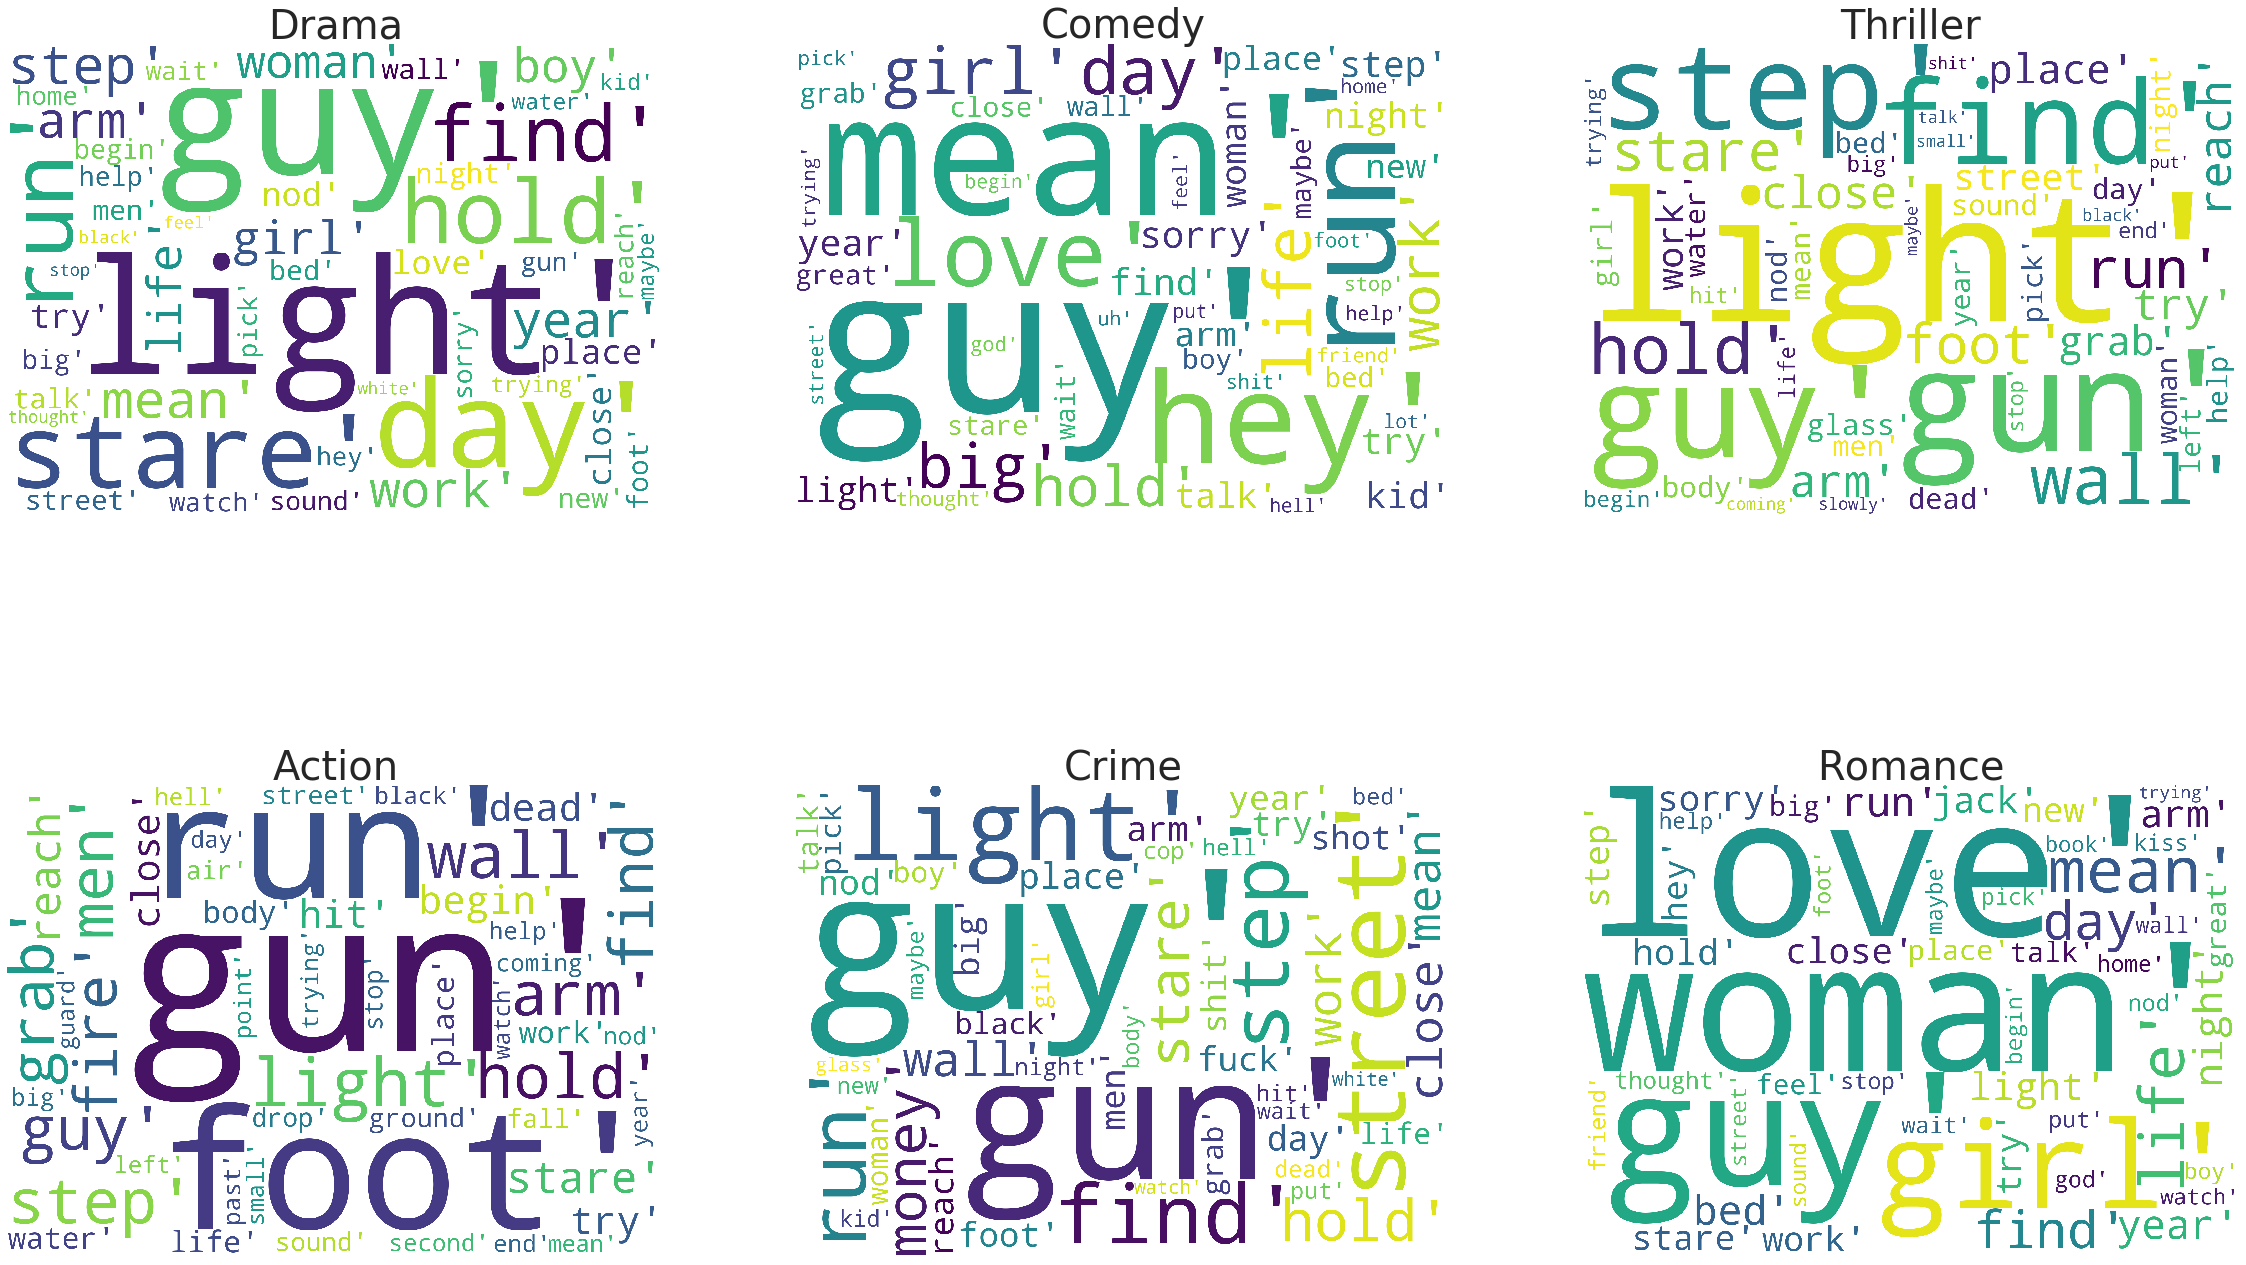

In [30]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

# drama
subset = df_lemm[df_lemm.Drama==1]
text = [line for line in subset.text.values]
cloud_drama = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Drama",fontsize=40)
plt.imshow(cloud_drama)


# comedy
subset = df_lemm[df_lemm.Comedy==1]
text = [line for line in subset.text.values]
cloud_comedy = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Comedy",fontsize=40)
plt.imshow(cloud_comedy)



# Thriller
subset = df_lemm[df_lemm.Thriller==1]
text = [line for line in subset.text.values]
cloud_thriller = WordCloud(stopwords=STOPWORDS,
                           background_color='white',
                           collocations=False,
                           max_words=50,
                           width=2500,
                           height=1800).generate(str(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Thriller",fontsize=40)
plt.imshow(cloud_thriller)


# action
subset = df_lemm[df_lemm.Action==1]
text = [line for line in subset.text.values]
cloud_action = WordCloud(stopwords=STOPWORDS,
                         background_color='white',
                         collocations=False,
                         max_words=50,
                         width=2500,
                         height=1800).generate(str(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Action",fontsize=40)
plt.imshow(cloud_action)


# crime
subset = df_lemm[df_lemm.Crime==1]
text = [line for line in subset.text.values]
cloud_crime = WordCloud(stopwords=STOPWORDS,
                        background_color='white',
                        collocations=False,
                        max_words=50,
                        width=2500,
                        height=1800).generate(str(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Crime",fontsize=40)
plt.imshow(cloud_crime)


# romance
subset = df_lemm[df_lemm.Romance==1]
text = [line for line in subset.text.values]
cloud_romance = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          max_words=50,
                          width=2500,
                          height=1800).generate(str(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Romance",fontsize=40)
plt.imshow(cloud_romance)
plt.savefig('../../wordcloud.png')
plt.get_cmap('winter_r')
plt.show()



### Train-Test-Split

In [4]:
#Additional data cleaning
df_lemm['text'] = df_lemm['text'].apply(nfx.remove_multiple_spaces)

In [5]:
#setting variable to text column
script_corpus = df_lemm['text'].apply(nfx.clean_text)

In [6]:
#Setting categories for top eleven genres
categories = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
print(categories)

['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


In [7]:
#Defining X and y variable prior to train-test-split
X = script_corpus
y = df_lemm[categories]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
#Preview the shape of training and test set
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (855,)
y_train Shape: (855, 11)
X_test Shape: (286,)
y_test Shape: (286, 11)


In [97]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(df_lemm, random_state=42, test_size=0.25, shuffle=True)

# print("Train Shape:", train.shape)
# print("Test Shape:", test.shape)

In [19]:
# train_text = train['text']
# test_text = test['text']

### Assigning weights

In [10]:
cate = pd.DataFrame(y.sum()).reset_index().rename(columns = {'index':'genres1',0:'count'})
cate.head()

genres1  count
0     Action    296
1  Adventure    179
2     Comedy    368
3      Crime    215
4      Drama    615

In [11]:
labels1 = cate.genres1.values

In [12]:
labels1

array(['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Fantasy',
       'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'], dtype=object)

In [13]:
cate['class_weight'] = len(cate) / cate['count']
class_weights = {}
for index, label in enumerate(labels1):
    class_weights[index] = cate[cate['genres1'] == label]['class_weight'].values[0]
    
cate.head()

genres1  count  class_weight
0     Action    296      0.037162
1  Adventure    179      0.061453
2     Comedy    368      0.029891
3      Crime    215      0.051163
4      Drama    615      0.017886

### Baseline Accuracy for each Category

Instead of training models to predict on all of the movie genres avaiable, there are some whose sample size is too small to provide any insight so I am only training models to predict on the genres that have at least 100 movies in their category.

Here I am viewing what baseline accuracy would look like for each genre. Below you can also view some class imbalance in a handful of the genre categories.

Normalized Value Count for Action Scripts
0    0.740578
1    0.259422
Name: Action, dtype: float64


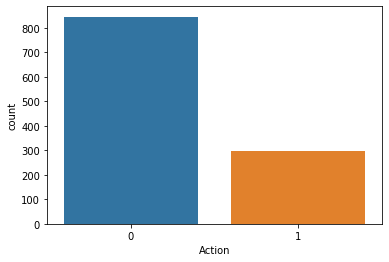

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Adventure Scripts
0    0.84312
1    0.15688
Name: Adventure, dtype: float64


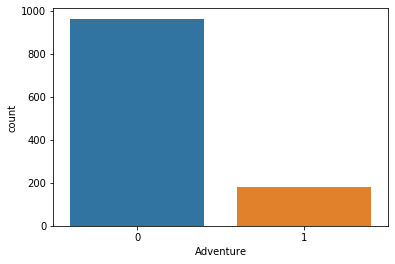

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Comedy Scripts
0    0.677476
1    0.322524
Name: Comedy, dtype: float64


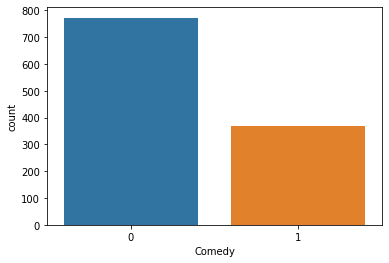

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Crime Scripts
0    0.811569
1    0.188431
Name: Crime, dtype: float64


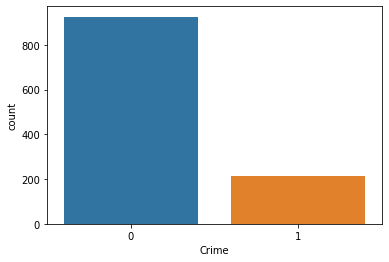

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Drama Scripts
1    0.539001
0    0.460999
Name: Drama, dtype: float64


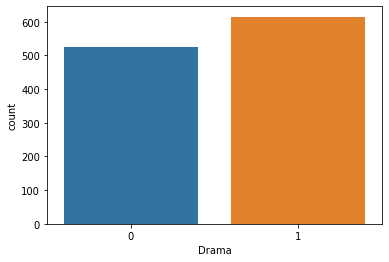

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Fantasy Scripts
0    0.903593
1    0.096407
Name: Fantasy, dtype: float64


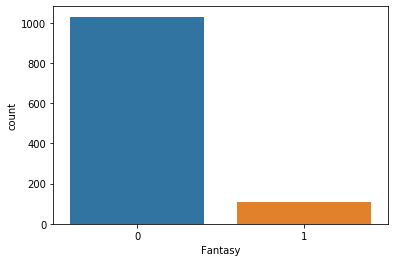

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Horror Scripts
0    0.864154
1    0.135846
Name: Horror, dtype: float64


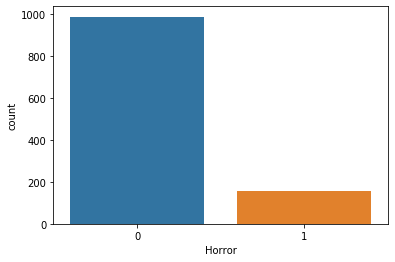

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Mystery Scripts
0    0.905346
1    0.094654
Name: Mystery, dtype: float64


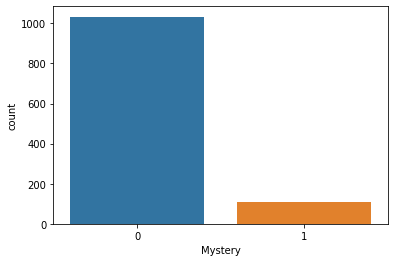

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Romance Scripts
0    0.829974
1    0.170026
Name: Romance, dtype: float64


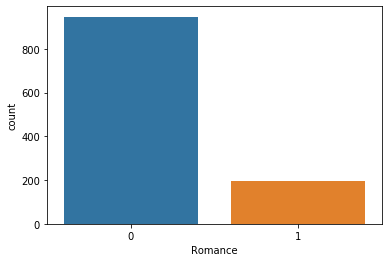

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Sci-Fi Scripts
0    0.851008
1    0.148992
Name: Sci-Fi, dtype: float64


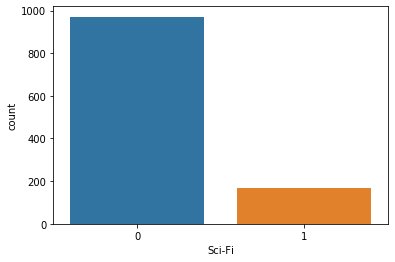

AxesSubplot(0.125,0.125;0.775x0.755) None


Normalized Value Count for Thriller Scripts
0    0.729185
1    0.270815
Name: Thriller, dtype: float64


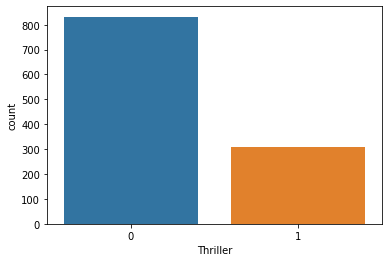

AxesSubplot(0.125,0.125;0.775x0.755) None




In [14]:
#View value counts to measure baseline accuracy
for category in categories:
    print('Normalized Value Count for {} Scripts'.format(category))
    print(y[category].value_counts(normalize=True))
    print(sns.countplot(y[category], ), plt.show())
    print("\n")
    

### TF-IDF

After train-test-split, I vectorize my train and test set and proceed with modeling.

In [15]:
tfidf = TfidfVectorizer(ngram_range=(1,4), min_df = 5 , max_features=25000, stop_words='english')

tfidf_train_lem = tfidf.fit_transform(X_train)
tfidf_test_lem = tfidf.transform(X_test)


In [16]:
non_zero_cols = tfidf_train_lem.nnz / float(tfidf_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 2653.2187134502924
Percentage of columns containing ZERO: 0.8938712514619883


In [59]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2', stop_words=stop_words_set)
# vectorizer.fit(train_text)
# vectorizer.fit(test_text)

In [21]:
# X_train = vectorizer.transform(train_text)
# y_train = train.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

# X_test = vectorizer.transform(test_text)
# y_test = test.drop(labels = ['file_name','text', 'movie_title', 'genre'], axis=1)

## LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=100, learning_method = 'online', max_iter=25, random_state=42, n_jobs=-1) 

In [18]:
train_topics = lda.fit_transform(tfidf_train_lem)
test_topics = lda.transform(tfidf_test_lem)

In [19]:
# For each topic (a row in the components_), sort the features (ascending) # Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(tfidf.get_feature_names())

In [20]:
import mglearn
# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                                sorting=sorting, topics_per_chunk=7, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       
--------      --------      --------      --------      --------      --------      --------      
bruno         kirk          shawn         establishing  ada           joel          lena          
org           burnett       fi user comment imsdbclimb roof    ruby          fait          ernesto       
www           graham        fi user commentlot pain      relay         muriel        ant           
gleam         matt          fi user       fuck care     mayan         claude        diego         
howre         jeannie       fi            selection     inner         su            organization  
behalf        gallagher     tim           talking talk  license       jim           formica       
acquired      merrill       james         mean sorry    hypocrite     corleone      yacht         
converted     mike          robot         blood red     knife         malcolm       bag           
sc

## Grid Search

In [90]:
from sklearn.model_selection import GridSearchCV

In [52]:
ovr_classifier.get_params().keys()

dict_keys(['estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [57]:
%%time

ovr_classifier = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',random_state = 42))


parameters = {'estimator__max_depth': [None, 80, 90, 100],
              'estimator__max_features': [2, 3, 5, 10, 15, 50],
              'estimator__min_samples_leaf': [3, 4, 5],
              'estimator__min_samples_split': [8, 10, 12],
              'estimator__criterion': ['gini', 'entropy'],
              'estimator__n_estimators': [50, 100, 200, 300, 1000]}

clf = GridSearchCV(ovr_classifier, parameters, scoring='f1_micro',verbose=2)
clf.fit(tfidf_train_lem, y_train)

print(clf.best_params_) 
print(clf.best_score_)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[CV] END estimator__criterion=gini, estimator__max_depth=None, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=8, estimator__n_estimators=50; total time=   3.2s
[CV] END estimator__criterion=gini, estimator__max_depth=None, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=8, estimator__n_estimators=50; total time=   3.1s
[CV] END estimator__criterion=gini, estimator__max_depth=None, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=8, estimator__n_estimators=50; total time=   4.8s
[CV] END estimator__criterion=gini, estimator__max_depth=None, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=8, estimator__n_estimators=50; total time=   3.2s
[CV] END estimator__criterion=gini, estimator__max_depth=None, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__mi

KeyboardInterrupt: 

## Modeling

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [102]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
rf = Pipeline([('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators = 50, criterion = 'entropy', class_weight='balanced',random_state = 42), n_jobs=-1))])

print("Random Forest Classifier")
print("\n")

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    rf.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    rf_train_prediction = rf.predict(tfidf_train_lem)
    rf_test_prediction = rf.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Training accuracy is {}'.format(accuracy_score(y_train[category], rf_train_prediction)))
    print('F1 train score is {}'.format(f1_score(y_train[category], rf_train_prediction)))
    print("--------------")
    print('Training accuracy is {}'.format(accuracy_score(y_test[category], rf_test_prediction)))
    print('F1 test score is {}'.format(f1_score(y_test[category], rf_test_prediction)))
    print("\n")


Random Forest Classifier


Processing Action scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.7937062937062938
F1 test score is 0.3516483516483517


Processing Adventure scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.8671328671328671
F1 test score is 0.1739130434782609


Processing Comedy scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.7342657342657343
F1 test score is 0.42424242424242425


Processing Crime scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.7937062937062938
F1 test score is 0.03278688524590164


Processing Drama scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.7587412587412588
F1 test score is 0.7952522255192878


Processing Fantasy scripts
Training accuracy is 1.0
F1 train score is 1.0
--------------
Training accuracy is 0.8951048951048951
F1 test sco

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 100)

classifier.fit(train_tfIdf, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

### Logistic Regression Pipeline

In [100]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag', class_weight='balanced'), n_jobs=-1))])

print("Logistic Regression Pipeline")
print("\n")

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    LogReg_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    LR_test_prediction = LogReg_pipeline.predict(tfidf_train_lem)
    LR_train_prediction = LogReg_pipeline.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Train accuracy is {}'.format(accuracy_score(y_train[category], LR_train_prediction)))
    print('F1 train score is {}'.format(f1_score(y_train[category], LR_train_prediction)))
    print("---------------------")
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], LR_test_prediction)))
    print('F1 test score is {}'.format(f1_score(y_test[category], LR_test_prediction)))
    print("\n")

Logistic Regression Pipeline


Processing Action scripts
Train accuracy is 0.9730994152046784
F1 train score is 0.9501084598698482
---------------------
Testing accuracy is 0.8216783216783217
F1 test score is 0.6277372262773723


Processing Adventure scripts
Train accuracy is 0.968421052631579
F1 train score is 0.9114754098360656
---------------------
Testing accuracy is 0.8706293706293706
F1 test score is 0.5316455696202531


Processing Comedy scripts
Train accuracy is 0.9578947368421052
F1 train score is 0.9359430604982205
---------------------
Testing accuracy is 0.7552447552447552
F1 test score is 0.631578947368421


Processing Crime scripts
Train accuracy is 0.9637426900584796
F1 train score is 0.9090909090909091
---------------------
Testing accuracy is 0.7727272727272727
F1 test score is 0.3689320388349514


Processing Drama scripts
Train accuracy is 0.9461988304093567
F1 train score is 0.9483146067415731
---------------------
Testing accuracy is 0.6818181818181818
F1 test score

### Linear Support Vector Classifier

In [104]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(class_weight='balanced'), n_jobs= -1))])

print("Linear Support Vector Classifier")
print("\n")

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting logistic regression model on train data
    SVC_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    SVC_train_prediction = SVC_pipeline.predict(tfidf_train_lem)
    SVC_test_prediction = SVC_pipeline.predict(tfidf_test_lem)
    
    # calculating test accuracy
    print('Training accuracy is {}'.format(accuracy_score(y_train[category], SVC_train_prediction)))
    print('F1 train score is {}'.format(f1_score(y_train[category], SVC_train_prediction)))
    print("-----------------------")
    print('Testing accuracy is {}'.format(accuracy_score(y_test[category], SVC_test_prediction)))
    print('F1 test score is {}'.format(f1_score(y_test[category], SVC_test_prediction)))
    print("\n")

Linear Support Vector Classifier


Processing Action scripts
Training accuracy is 0.9964912280701754
F1 train score is 0.9932885906040269
-----------------------
Testing accuracy is 0.8146853146853147
F1 test score is 0.5954198473282442


Processing Adventure scripts
Training accuracy is 0.9941520467836257
F1 train score is 0.9823321554770319
-----------------------
Testing accuracy is 0.8741258741258742
F1 test score is 0.5263157894736842


Processing Comedy scripts
Training accuracy is 0.9929824561403509
F1 train score is 0.988929889298893
-----------------------
Testing accuracy is 0.7517482517482518
F1 test score is 0.6162162162162161


Processing Crime scripts
Training accuracy is 0.9894736842105263
F1 train score is 0.9717868338557993
-----------------------
Testing accuracy is 0.7797202797202797
F1 test score is 0.3636363636363637


Processing Drama scripts
Training accuracy is 0.9941520467836257
F1 train score is 0.9943630214205186
-----------------------
Testing accuracy is 0.

### Multinomial Naive Bayes Pipeline

In [115]:
%%time

# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(alpha = .005, fit_prior = False)))])

print("Multinomial Naive Bayes Pipeline")
print("\n")

for category in categories:
    print('Processing {} scripts'.format(category))
    
    # Fitting Naive Bayes model on train data
    NB_pipeline.fit(tfidf_train_lem, y_train[category])
    
    # predict on test set
    NB_test_prediction = NB_pipeline.predict(tfidf_test_lem)
    NB_train_prediction = NB_pipeline.predict(tfidf_train_lem)
    
    # calculating test accuracy
    print('Testing accuracy is {}'.format(round(accuracy_score(y_train[category], NB_train_prediction) * 100,2)))
    print('F1 score is {}'.format(round(f1_score(y_train[category], NB_train_prediction) * 100, 2)))
    print("-----------------------")
    print('Testing accuracy is {}'.format(round(accuracy_score(y_test[category], NB_test_prediction) * 100,2)))
    print('F1 score is {}'.format(round(f1_score(y_test[category], NB_test_prediction) * 100,2)))
    print("\n")

Multinomial Naive Bayes Pipeline


Processing Action scripts
Testing accuracy is 97.78
F1 score is 95.84
-----------------------
Testing accuracy is 84.97
F1 score is 69.06


Processing Adventure scripts
Testing accuracy is 97.89
F1 score is 93.92
-----------------------
Testing accuracy is 88.81
F1 score is 60.98


Processing Comedy scripts
Testing accuracy is 96.61
F1 score is 94.79
-----------------------
Testing accuracy is 73.43
F1 score is 60.82


Processing Crime scripts
Testing accuracy is 97.66
F1 score is 93.94
-----------------------
Testing accuracy is 82.87
F1 score is 55.86


Processing Drama scripts
Testing accuracy is 96.26
F1 score is 96.47
-----------------------
Testing accuracy is 69.23
F1 score is 73.65


Processing Fantasy scripts
Testing accuracy is 98.48
F1 score is 92.49
-----------------------
Testing accuracy is 88.46
F1 score is 35.29


Processing Horror scripts
Testing accuracy is 98.6
F1 score is 95.0
-----------------------
Testing accuracy is 85.66
F1 sc

In [69]:
NB_pipeline.fit(tfidf_train_lem, y_train['Thriller'])

Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=MultinomialNB(alpha=0.005,
                                                             fit_prior=False)))])

In [70]:
y_preds = NB_pipeline.predict(tfidf_test_lem[:5])

In [71]:
y_preds

array([1, 0, 1, 0, 0])

In [67]:
# y_preds > 0.5

In [72]:
print(y_test['Thriller'][:5])

1071    0
907     0
290     1
844     0
333     1
Name: Thriller, dtype: int64


In [38]:
y_pred_proba = NB_pipeline.predict_proba(tfidf_test_lem)

In [39]:
y_pred_proba

array([[3.02101686e-01, 6.97898314e-01],
       [8.33785204e-01, 1.66214796e-01],
       [3.76783772e-01, 6.23216228e-01],
       [5.74703125e-01, 4.25296875e-01],
       [8.70933594e-01, 1.29066406e-01],
       [8.87143757e-01, 1.12856243e-01],
       [8.84602587e-01, 1.15397413e-01],
       [8.66068248e-01, 1.33931752e-01],
       [8.43740328e-01, 1.56259672e-01],
       [3.64590423e-01, 6.35409577e-01],
       [9.98778439e-01, 1.22156102e-03],
       [8.26179381e-01, 1.73820619e-01],
       [6.52962584e-01, 3.47037416e-01],
       [4.91269502e-01, 5.08730498e-01],
       [9.63208926e-01, 3.67910743e-02],
       [1.10170906e-01, 8.89829094e-01],
       [8.83603470e-01, 1.16396530e-01],
       [9.99494557e-01, 5.05442605e-04],
       [2.20509842e-01, 7.79490158e-01],
       [4.58270032e-01, 5.41729968e-01],
       [6.36821695e-01, 3.63178305e-01],
       [9.09327263e-01, 9.06727374e-02],
       [7.79618824e-01, 2.20381176e-01],
       [5.08554929e-01, 4.91445071e-01],
       [8.908550

### Gaussian Naive Bayes

In [40]:
!pip install scikit-multilearn

In [ ]:
%%time

#Binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import hamming_loss

# initialize binary relevance multi-label classifier with a gaussian naive bayes base classifier
GNB = BinaryRelevance(GaussianNB())

#Fitting Naive Bayes model on train data
GNB.fit(tfidf_train_lem, y_train)
    
# # predict on test set
GNB_train_prediction = GNB.predict(tfidf_train_lem)
GNB_test_prediction = GNB.predict(tfidf_test_lem)


# calculating accuracy
print('Training accuracy is {}'.format(round(accuracy_score(y_test, GNB_train_prediction) *100, 2)))
print('F1 train score is {}'.format(round(f1_score(y_test, GNB_train_prediction, average="samples") *100, 2)))
print('Train Hamming loss: {}'.format(round(hamming_loss(y_test, GNB_train_prediction) *100, 2)))
print("-----------------------")
print('Testing accuracy is {}'.format(round(accuracy_score(y_test, GNB_test_prediction) *100, 2)))
print('F1 test score is {}'.format(round(f1_score(y_test, GNB_test_prediction, average="samples") *100, 2)))
print('Test Hamming loss: {}'.format(round(hamming_loss(y_test, GNB_test_prediction) *100, 2)))
print("\n")

### Classifier Chain

In [42]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [43]:
%%time

# initialize classifier chains multi-label classifier
chain = ClassifierChain(LogisticRegression(solver='newton-cg', class_weight='balanced'))

# Training logistic regression model on train data
chain.fit(tfidf_train_lem, y_train)

# predict
chain_predictions = chain.predict(tfidf_test_lem)

# accuracy
print("Accuracy = ",accuracy_score(y_test,chain_predictions))
print('F1 score is {}'.format(f1_score(y_test, chain_predictions, average="samples")))
print('Hamming loss: {}'.format(hamming_loss(y_test, chain_predictions)))
print("\n")

Accuracy =  0.06993006993006994
F1 score is 0.46445170990625534
Hamming loss: 0.12285441830896376


CPU times: user 51.9 s, sys: 24.4 s, total: 1min 16s
Wall time: 22.2 s


### Label Powerset

In [44]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

In [45]:
%%time

# initialize label powerset multi-label classifier
powerset = LabelPowerset(LogisticRegression(solver='newton-cg', class_weight='balanced'))

# train
powerset.fit(tfidf_train_lem, y_train)

# predict
powerset_predictions = powerset.predict(tfidf_test_lem)

# accuracy
print("Accuracy = ",accuracy_score(y_test,powerset_predictions))
print('F1 score is {}'.format(f1_score(y_test, powerset_predictions, average="samples")))
print('Hamming loss: {}'.format(hamming_loss(y_test, powerset_predictions)))
print("\n")

Accuracy =  0.027972027972027972
F1 score is 0.33247686656777564
Hamming loss: 0.17450731087094723


CPU times: user 13.9 s, sys: 2.63 s, total: 16.5 s
Wall time: 4.29 s


### Adapted Algorithm

In [51]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

In [54]:
from skmultilearn.adapt import MLkNN

mlknn_classifier = MLkNN()

# train
mlknn_classifier.fit(tfidf_train_lem, y_train)

# predict
mlknn_predictions = mlknn_classifier.predict(tfidf_test_lem)

# accuracy
print("Accuracy = ",accuracy_score(y_test, mlknn_predictions))
print('F1 score is {}'.format(f1_score(y_test, mlknn_predictions, average="samples")))
print('Hamming loss: {}'.format(hamming_loss(y_test, mlknn_predictions)))
print("\n")

AttributeError: 'DataFrame' object has no attribute 'getformat'

In [48]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

parameters = {'k': range(1,9), 's': [0.5, 0.7, 1.0]}

clf = GridSearchCV(MLkNN(), parameters, scoring='f1_macro')
clf.fit(tfidf_train_lem, y_train)

print (clf.best_params_, clf.best_score_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metric

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=6 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=8 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/ec2-user/anaconda3/envs/pyt

{'k': 1, 's': 0.5} 0.16028982455264137


In [41]:
%%time

classifier_new = MLkNN()

# Note that this classifier can throw up errors when handling sparse matrices.

x_train = lil_matrix(tfidf_test_lem).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(tfidf_test_lem).toarray()

# train
classifier_new.fit(x_train, y_train)

# predict
predictions_new = classifier_new.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print('F1 score is {}'.format(f1_score(y_test, predictions_new, average="samples")))
print('Hamming loss: {}'.format(hamming_loss(y_test, predictions_new)))
print("\n")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


IndexError: list index out of range

# Keras

In [ ]:
!conda install -c conda-forge keras

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::python-language-server==0.31.7=py36_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::nb_conda==2.2.1=py36_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::pyopenssl==19.1.0=py36_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/noarch::boto3==1.9.162=py_0
  - defaults/linux-64::s3transfer==0.2.1=py36_0
  - defaults/linux-64::nbconvert

In [52]:
!pip install keras

In [54]:
!pip install tensorflow

     |████████████████████████████████| 394.3 MB 12 kB/s s eta 0:00:01  |▊                               | 9.1 MB 5.5 MB/s eta 0:01:11
     |████████████████████████████████| 127 kB 66.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 47.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 51.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 898 kB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 264 kB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 70.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 70.5 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=ac63a733b53fc4308b

In [55]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [56]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

In [ ]:
X, y1 = make_classification(n_samples=10, n_features=100, n_informative=30, n_classes=3, random_state=1)
y2 = shuffle(y1, random_state=1)
y3 = shuffle(y1, random_state=2)
Y = np.vstack((y1, y2, y3)).T
n_samples, n_features = X.shape # 10,100
n_outputs = Y.shape[1] # 3
n_classes = 3
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(X, Y).predict(X)